In [1]:
!pip3 install torch torchvision

In [2]:
!pip3 install fastai

In [3]:
# helper functions for fast.ai

# def plot_function(f, tx=None, ty=None, title=None, min=-2, max=2, figsize=(6,4)):
#     x = torch.linspace(min,max)
#     fig,ax = plt.subplots(figsize=figsize)
#     ax.plot(x,f(x))
#     if tx is not None: ax.set_xlabel(tx)
#     if ty is not None: ax.set_ylabel(ty)
#     if title is not None: ax.set_title(title)
        
        
def label_func(fname):
    '''
    function to grab folder name as label name
    '''
    return fname.parent.name

def get_dls(bs, size, augment=True):
    '''
    function to get datablocks
    '''
    if augment:
        batch_tfms=[*aug_transforms(size=size, 
                                    max_zoom=1.1, 
                                    min_scale=0.75), 
                    Normalize.from_stats(*imagenet_stats)]
    else:
        batch_tfms=[*aug_transforms(size=size, min_scale=0.75), Normalize.from_stats(*imagenet_stats)]
        
    dblock = DataBlock(blocks = (ImageBlock, CategoryBlock),
                       get_items=get_image_files, 
                       splitter=RandomSplitter(seed=42),
                       get_y=label_func,
                       item_tfms=Resize(460),
                       batch_tfms=batch_tfms)
    return dblock.dataloaders(path, bs=128)


def new_resnet(pretrained):
    '''
    fix for cnn_learner module using non-standard pre-trained models
    '''
    return default_res50

def accuracy_topk(output, target, topk=(3,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

def random_test_image(img_dir, categories):
    """Pick a random test image from specified dir"""
    c = np.random.choice(categories)
    root = img_dir + c + '/'
    img_path = root + np.random.choice(os.listdir(root))
    print(img_path)
    return img_path

In [5]:
from fastai.vision.all import *

In [7]:
# setting path variables 
Path.BASE_PATH = Path('../../MelvinWevers#9512/rotate_training')
Path.BASE_PATH.ls()
path = Path.BASE_PATH

In [7]:
# th architecture to use
arch = 'resnet50'

# (down)load the pre-trained weights
model_weights = '%s_places365.pth.tar' % arch
if not os.access(model_weights, os.W_OK):
    weight_url = 'http://places2.csail.mit.edu/models_places365/' + model_weights
    os.system('wget ' + weight_url)
    
places_res50 = torch.load(model_weights,  
                          map_location=lambda storage, 
                          loc: storage)

default_res50 = models.resnet50()
state_dict = places_res50['state_dict'] 
new_state_dict = OrderedDict()

for key in state_dict.keys():
    new_state_dict[key[7:]]= state_dict[key]
    

default_res50.fc = torch.nn.Linear(2048, 365) # Matching with default res50 dense layer (change number of labels?)
default_res50.load_state_dict(new_state_dict)

<All keys matched successfully>

In [8]:
# model_ft = models.resnet18(pretrained=True)
# num_ftrs = model_ft.fc.in_features
# # Here the size of each output sample is set to 2.
# # Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
# model_ft.fc = nn.Linear(num_ftrs, 2)

# model_ft = model_ft.to(device)


In [9]:
def new_resnet(pretrained):
    '''
    fix for cnn_learner module using non-standard pre-trained models
    '''
    return model

In [10]:
def get_model(model, pretrained=False, progress=True, **kwargs):
    """model: function to load the model, e.g. resnet18
        pretrained, progress: to be passed to the model function
    """
    m = model(pretrained=pretrained, progress=progress, **kwargs)
    num_ftrs = m.fc.in_features
    m.fc = nn.Linear(num_ftrs, 2)
    
    return m

In [11]:
learn = cnn_learner(get_dls(64, 224, augment=True), 
                    partial(get_model, model=resnet18),
                    metrics=[accuracy,
                             error_rate])

learn.fit_one_cycle(50, 3e-3, cbs=[SaveModelCallback(monitor='valid_loss', 
                                                    
                                                   fname='rotation'), 
                                   EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=5)])

/opt/conda/lib/python3.7/site-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/ucloud/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.421390,0.235031,0.917717,0.082283,03:05
1,0.235242,0.125612,0.962336,0.037664,00:51
2,0.165661,0.099509,0.971522,0.028478,00:51
3,0.128593,0.084724,0.974672,0.025328,00:50
4,0.108882,0.083699,0.974803,0.025197,00:51
5,0.098951,0.071096,0.974934,0.025066,00:51
6,0.084974,0.070769,0.977822,0.022178,00:51
7,0.089157,0.067374,0.978740,0.021260,00:51
8,0.082337,0.064783,0.979265,0.020735,00:50
9,0.082427,0.064760,0.978478,0.021522,00:50


Better model found at epoch 0 with valid_loss value: 0.23503106832504272.
Better model found at epoch 1 with valid_loss value: 0.12561197578907013.
Better model found at epoch 2 with valid_loss value: 0.09950877726078033.
Better model found at epoch 3 with valid_loss value: 0.08472412079572678.
Better model found at epoch 4 with valid_loss value: 0.08369940519332886.
Better model found at epoch 5 with valid_loss value: 0.0710955411195755.
Better model found at epoch 6 with valid_loss value: 0.07076896727085114.
Better model found at epoch 7 with valid_loss value: 0.06737406551837921.
Better model found at epoch 8 with valid_loss value: 0.06478293985128403.
Better model found at epoch 9 with valid_loss value: 0.06476036459207535.
No improvement since epoch 5: early stopping


In [12]:
learn.export('./models/rotation.pkl')

In [13]:
learn.load('rotation')

In [8]:
data = get_dls(128, 224)
classes = data.vocab

/opt/conda/lib/python3.9/site-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


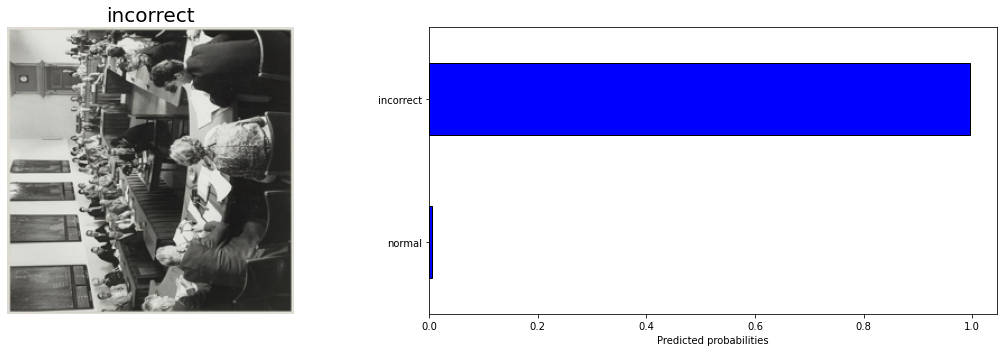

In [56]:
valid_paths = data.valid_ds.items
random_path = random.choice(valid_paths)
label, y, output = learn.predict(random_path)
img = Image.open(random_path)
img = img.resize((256, 256))
probs, preds = output.topk(2)
top_classes = [classes[i] for i in preds]
top5 = list(probs)
result = pd.DataFrame({'p': probs}, index=top_classes)


plt.figure(figsize=(16,5))
ax = plt.subplot(1, 2, 1)
ax.set_title(label, size=20)
ax = plt.imshow(img, cmap='gray')

plt.axis('off')
ax = plt.subplot(1, 2, 2)
result.sort_values('p')['p'].plot.barh(color='blue', edgecolor='k', ax=ax)
plt.xlabel('Predicted probabilities')
plt.tight_layout()
plt.savefig('dining_room.png', dpi=300, bbox_inches='tight')

In [57]:
interp = ClassificationInterpretation.from_learner(learn)

In [19]:
interp.most_confused(min_val=5)

[('geestelijken', 'uitreiking_huldiging', 7),
 ('scheepswerf', 'bouwplaats', 6),
 ('theater', 'historisch_toneelstuk', 6),
 ('gebouw', 'villa', 5),
 ('haven', 'bouwplaats', 5),
 ('muziek_optreden', 'uitreiking_huldiging', 5)]

In [58]:
interp.print_classification_report()

              precision    recall  f1-score   support

   incorrect       0.98      0.99      0.99      5719
      normal       0.98      0.94      0.96      1901

    accuracy                           0.98      7620
   macro avg       0.98      0.97      0.97      7620
weighted avg       0.98      0.98      0.98      7620



In [24]:
learn.save('DeBoer_places')

Path('models/DeBoer_places.pth')

In [1]:
learn = cnn_learner(get_dls(128, 224, augment=True), 
                    new_resnet,
                    #models.resnet34,
                    metrics=[top_k_accuracy, 
                             accuracy,
                             error_rate])

NameError: name 'cnn_learner' is not defined

In [27]:
learn.load('DeBoer_places')

In [30]:
label, y, output = learn.predict('../../MelvinWevers#9512/train/auto/NL-HlmNHA_1478_02871_G.jpg')

tensor([0.8980, 0.0447, 0.0240, 0.0071, 0.0054])

In [38]:
probs, preds = output.topk(5)
top_classes = [classes[i] for i in preds]
top5 = list(probs)
result = pd.DataFrame({'p': probs}, index=top_classes)

In [39]:
result

,p
auto,0.897982
auto_ongeluk,0.044680
autorace,0.023964
dieren,0.007090
strand,0.005352
